In [54]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import matplotlib.lines as mlines
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns
import os
import sys
import pickle
from glob import glob

from olympus import Surface
from olympus.campaigns import ParameterSpace, Campaign
from olympus.objects import ParameterContinuous
from atlas.planners.gp.planner import GPPlanner

sns.set(style='ticks', context='notebook', font_scale=1.2)
from cmcrameri import cm


In [3]:
# Golem colormap
_reference_colors = ['#008080', '#70a494', '#b4c8a8', '#f6edbd', '#edbb8a', '#de8a5a','#ca562c']
_cmap = LinearSegmentedColormap.from_list('golem', _reference_colors)
_cmap_r = LinearSegmentedColormap.from_list('golem_r', _reference_colors[::-1])
# plt.register_cmap(cmap=_cmap)
# plt.register_cmap(cmap=_cmap_r)

cmap = cm.nuuk

def get_golem_colors(n):
    _cmap = plt.get_cmap('golem')
    return [_cmap(x) for x in np.linspace(0, 1, n)]

def plot_contour(ax, X0, X1, y, xlims, ylims, vlims=[None, None], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_color='k', contour_alpha=1, cbar=False, cmap=cmap):
    # background surface
    if contour_lines is True:
        contours = ax.contour(X0, X1, y, n_contour_lines, colors=contour_color, alpha=contour_alpha, linestyles='dashed')
        if contour_labels is True:
            _ = ax.clabel(contours, inline=True, fontsize=labels_fs, fmt=labels_fmt)
    mappable = ax.imshow(y, extent=[xlims[0],xlims[1],ylims[0],ylims[1]], 
                         origin='lower', cmap=cmap, alpha=alpha, vmin=vlims[0], vmax=vlims[1])
    
    if cbar is True:
        cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.5)
        
    return mappable

def plot_constr_surface(surface, ax=None, N=100):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

    x0 = np.linspace(0,1,N)
    x1 = np.linspace(0,1,N)
    X0, X1 = np.meshgrid(x0,x1)
    X = np.array([X0.flatten(), X1.flatten()]).T
    y = np.array(surface.run(X)).flatten()
    Y = np.reshape(y, newshape=np.shape(X0))

    _ = plot_contour(ax, X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=1, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_alpha=0.8, cbar=False, cmap=cmap) #'golem'
    for param in surface.minima:
        x_min = param['params']
        ax.scatter(x_min[0], x_min[1], s=200, marker='*', color='#ffc6ff', zorder=20)
    
    #y_feas = np.array(surface.eval_constr(X))
    #Y_feas = np.reshape(y_feas, newshape=np.shape(X0))
    #ax.imshow(Y_feas, extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.5, interpolation='none')
    
    
def plot_constr_surface_cat(surface, ax=None, mark_min=False):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
        
        
    domain = np.arange(21)
    Z = np.zeros((21, 21))
    Z_feas = np.empty((21, 21))
    X = []
    for x_index, x in enumerate(domain):
        for y_index, y in enumerate(domain):
            x = ['x_{}'.format(x_index), 'x_{}'.format(y_index)]
            X.append(x)
            loss_value = surface.run(x)
            feas_bool = surface.eval_constr([x])
            Z[y_index, x_index] = loss_value
            #print(loss_value)
            #print(feas_bool)
            #print(x)
            #Z_feas[y_index, x_index] = all(feas_bool)
            
    # scale Camel for visualization 
    if type(surface).__name__ == 'CatCamelConstr':
        Z = np.log(Z)

    ax.imshow(Z, origin='lower', cmap = cmap)
    #ax.imshow(Z_feas, origin='lower', cmap='gray', alpha=0.5, interpolation='none')
    
    if mark_min is True:
        X_best = surface.str2array(surface.best)
        _ = ax.scatter(X_best[0], X_best[1], marker='*', s=200, color='#ffc6ff', linewidth=2, zorder=20)
        
        
def plot_constr_surface_with_scatter(ax, surface, data, repeat=0):

    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    plot_constr_surface(surface, ax=ax, N=100)

    repeat = 0
    X = data[repeat].loc[:, ['x0', 'x1']]
    #mask = surface.eval_constr(X.to_numpy())
    mask = np.array([True for _ in range(len(X))])
    X_feas = X[mask]
    X_infs = X[~mask]

    ax.scatter(X_feas['x0'], X_feas['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)
    ax.scatter(X_infs['x0'], X_infs['x1'], marker='X', s=100, color='white', edgecolor='k', zorder=10)
    
def calc_frac_feasible(surface, N=10000, categorical=False):
    if categorical is False:
        X = np.random.uniform(0, 1, size=(N, 2))
        y_feas = np.array(surface.eval_constr(X))
    else:
        domain = np.arange(surface.num_opts)
        y_feas = []
        for x_index, x in enumerate(domain):
            for y_index, y in enumerate(domain):
                x = ['x_{}'.format(x_index), 'x_{}'.format(y_index)]
                feas_bool = surface.eval_constr(x)
                y_feas.append(feas_bool)
    return sum(y_feas) / len(y_feas)


def plot_binary_scatter(surface, pkl_file, ax, n=0):
    with open(pkl_file, 'rb') as content:
        data = pickle.load(content)
    X = data[n].loc[:, ['x0', 'x1']]
    mask = surface.eval_constr(X.to_numpy())
    X_feas = X[mask]
    X_infs = X[~mask]
    
    ax.scatter(X_feas['x0'], X_feas['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)
    ax.scatter(X_infs['x0'], X_infs['x1'], marker='X', s=100, color='white', edgecolor='k', zorder=10)
    

    
def plot_binary_scatter_cat(surface, pkl_file, ax, n=0):
    with open(pkl_file, 'rb') as content:
        data = pickle.load(content)
    X = data[n].loc[:, ['x0', 'x1']]
    mask = surface.eval_constr(X.to_numpy())
    X_feas_ = X[mask].values
    X_infs_ = X[~mask].values
    
    X_feas = []
    for x_ in X_feas_:
        x = [int(x_[0][2:]), int(x_[1][2:])]
        X_feas.append(x)
    
    X_infs = []
    for x_ in X_infs_:
        x = [int(x_[0][2:]), int(x_[1][2:])]
        X_infs.append(x)

    X_infs = np.array(X_infs)
    X_feas = np.array(X_feas)
    
    ax.scatter(X_feas[:,0], X_feas[:,1], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)
    ax.scatter(X_infs[:,0], X_infs[:,1], marker='X', s=100, color='white', edgecolor='k', zorder=10)
    

In [4]:
def get_traces_min(data, replace_nan=True):
    traces_min = []
    for df in data:
        trace = df.loc[:, 'obj'].to_numpy()
        # if first is nan, replace with first non-nan
        if replace_nan is True:
            if np.isnan(trace[0]):
                for val in trace[1:]:
                    if not np.isnan(val):
                        trace[0] = val
                        break
        trace_min = [np.nanmin(trace[:i+1]) for i in range(len(trace))]
        traces_min.append(trace_min)
    return np.array(traces_min)

def plot_min_trace_mean(
    data, ax=None, color=None, label=None, categorical=False, stde=False, unc=True, shift=0.0, maximize=False,
    linewidth=4, 
):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
    
    if not maximize:
        if categorical is True:
            traces_min = get_traces_min_for_categorical(data) - shift
        else:
            traces_min = get_traces_min(data) - shift
    else:
        traces_min = get_traces_max(data)-shift
    
    mean = np.nanmean(traces_min, axis=0)
    if stde is True:
        # standard error
        stde = np.nanstd(traces_min, axis=0, ddof=1) / np.sqrt(np.shape(traces_min)[0] - 1)
    else:
        # standard deviation
        stde = np.nanstd(traces_min, axis=0, ddof=1)
        
    x = range(1, np.shape(traces_min)[1]+1, 1)

    ax.plot(x, mean, color='#444444', linewidth=linewidth+1)
    plot_ = ax.plot(x, mean, color=color, linewidth=linewidth, label=label)
    
    if unc is True:
        ax.fill_between(x, y1=mean - 1.96*stde, y2=mean + 1.96*stde, alpha=0.2, color=color)
        ax.plot(x, mean - 1.96*stde, color=color, linewidth=1, alpha=0.5)
        ax.plot(x, mean + 1.96*stde, color=color, linewidth=1, alpha=0.5)
        
    return plot_
        

In [4]:
# load results
res = pickle.load(open('results.pkl', 'rb'))
params = res.observations.get_params()
objs = res.observations.get_values()

df = pd.DataFrame({'x0': params[:, 0].flatten(), 'x1': params[:, 1].flatten(), 'obj': objs[:].flatten()})
df.head()

,x0,x1,obj
0,0.671237,0.900064,163.386876
1,0.600697,0.104701,3.815395
2,0.884479,0.860608,132.424995
3,0.691453,0.733102,112.280514
4,0.643196,0.389002,29.109701


/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


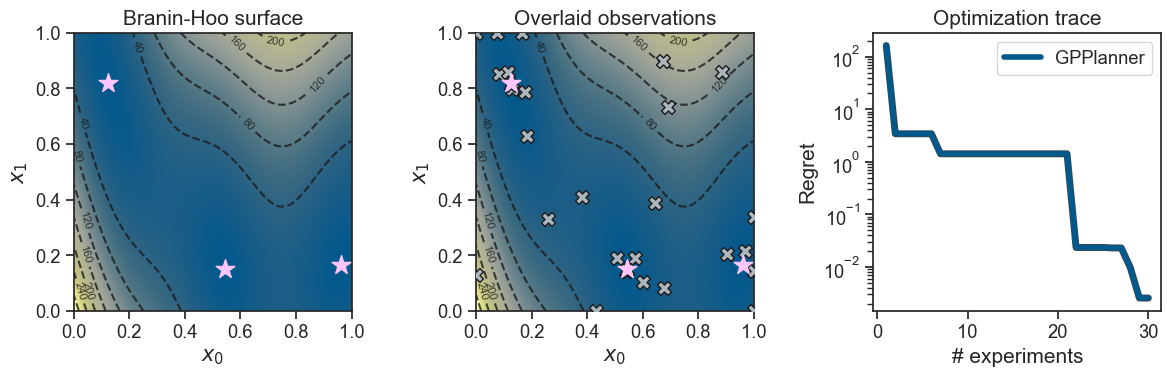

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))


# plain surface
surface = Surface(kind='Branin')
plot_constr_surface(surface=surface, ax=axes[0], N=100)

axes[0].set_xlabel(r'$x_0$', fontsize=15)
axes[0].set_ylabel(r'$x_1$', fontsize=15)
axes[0].set_title('Branin-Hoo surface', fontsize=15)


# surface with observations
plot_constr_surface_with_scatter(axes[1], surface, [df], repeat=0)

axes[1].set_xlabel(r'$x_0$', fontsize=15)
axes[1].set_ylabel(r'$x_1$', fontsize=15)
axes[1].set_title('Overlaid observations', fontsize=15)



# optimization trace
plot_min_trace_mean(
    [df], ax=axes[2], color='#02598c', label='GPPlanner', 
    categorical=False, stde=False, unc=True, 
    shift=surface.minima[0]['value'], maximize=False,
    linewidth=4, 
)

axes[2].set_yscale('log')
axes[2].legend(loc='upper right')
axes[2].set_xlabel('# experiments', fontsize=15)
axes[2].set_ylabel('Regret', fontsize=15)
axes[2].set_title('Optimization trace', fontsize=15)


plt.tight_layout()
plt.savefig('2d_branin_minimal_code.png', dpi=300)

## Conceptual BO of 1d - cont function

In [5]:
def measure(x):
    return np.sin(13*x) * np.exp(-0.4*np.pi*x)

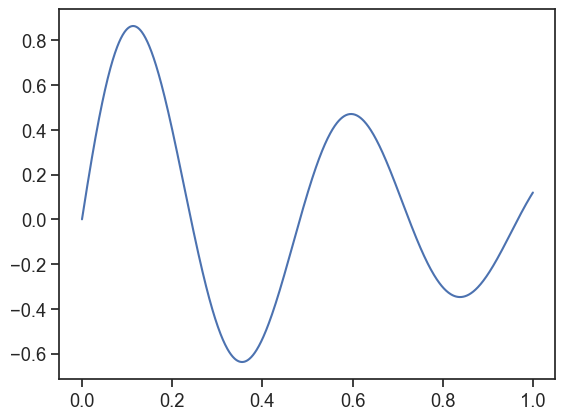

In [6]:
domain = np.linspace(0., 1., 1000)
plt.plot(domain, measure(domain))

In [7]:
param_space = ParameterSpace()
param_space.add(ParameterContinuous(low=0., high=1.))

planner = GPPlanner(goal='minimize', num_init_design=3)
planner.set_param_space(param_space)

campaign = Campaign()
campaign.set_param_space(param_space)

# plotting data
surr_mus = []
surr_sigmas = []
acqf_vals = []
while campaign.num_obs  < 20: 
    if campaign.num_obs >3 : 
        # get predictions of reg surrogate mu and sigma, acqf, 
        surr_mu, surr_sigma = planner.reg_surrogate(X=domain.reshape(-1, 1), return_np=True)
        acqf_val = planner.acquisition_function(X=domain.reshape(-1, 1), return_np=True, normalize=True)
        surr_mus.append(surr_mu)
        surr_sigmas.append(surr_sigma)
        acqf_vals.append(acqf_val)
        
        
    samples = planner.recommend(campaign.observations)
    for sample in samples:
        y = measure(sample.to_array())
        campaign.add_observation(sample, y)
        
        

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

ATLAS [INFO] Generating 1 initial design points (batch 1/3)

ATLAS [INFO] Generating 1 initial design points (batch 2/3)

ATLAS [INFO] Generating 1 initial design points (batch 3/3)

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.067 sec

────────────────────── Acquisition function optimization ───────────────────────

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.017 sec

────────────────────── Acquisition function optimization ───────────────────────

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.031 sec

────────────────────── Acquisition function optimization ───────────────────────

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.04 sec

────────────────────── Acquisition function optimization ───────────────────────

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.035 sec

────────────────────── Acquisition function optimization ───────────────────────

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.063 sec

────────────────────── Acquisition function optimization ───────────────────────

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.067 sec

────────────────────── Acquisition function optimization ───────────────────────

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.061 sec

────────────────────── Acquisition function optimization ───────────────────────

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.059 sec

────────────────────── Acquisition function optimization ───────────────────────

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.055 sec

────────────────────── Acquisition function optimization ───────────────────────

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.066 sec

────────────────────── Acquisition function optimization ───────────────────────

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.051 sec

────────────────────── Acquisition function optimization ───────────────────────

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.054 sec

────────────────────── Acquisition function optimization ───────────────────────

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.041 sec

────────────────────── Acquisition function optimization ───────────────────────

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.073 sec

────────────────────── Acquisition function optimization ───────────────────────

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.06 sec

────────────────────── Acquisition function optimization ───────────────────────

───────────────────── Training regression surrogate model ──────────────────────

/Users/rileyhickman/mambaforge/envs/atlas_aag/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ATLAS [INFO] Regression surrogate GP trained in 0.078 sec

────────────────────── Acquisition function optimization ───────────────────────

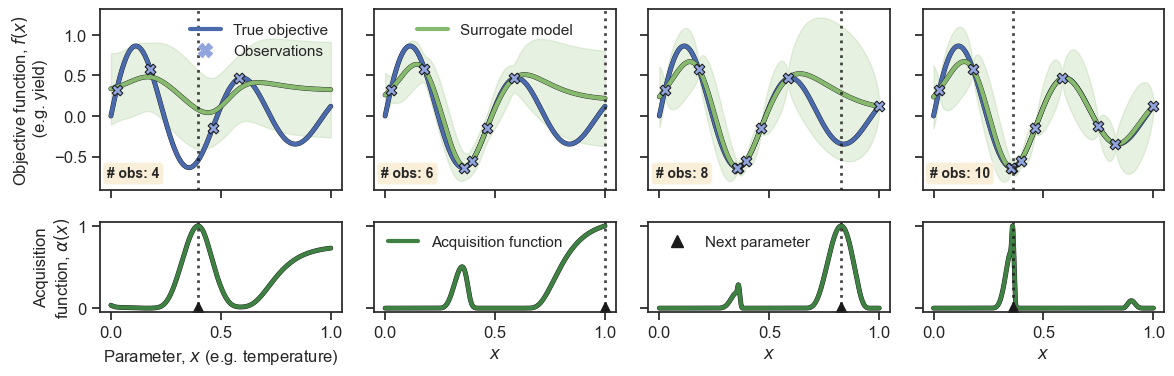

In [80]:
fig, axes = plt.subplots(2, 4, figsize=(12, 4), gridspec_kw={'height_ratios': [2., 1.]}, sharex=True, sharey='row')

# color palette
c_obj = '#4a6aac'
c_obs = '#92a4de'
c_pred = '#87b96f'
c_acqf = '#3f8043'
c_acqf2 = '#ddd8fe'

domain_ = domain.reshape(-1, 1)
true_obj = measure(domain_)

# label axes
axes[0, 0].set_ylabel(r'Objective function, $f(x)$'+'\n (e.g. yield)',fontsize=12)
axes[1, 0].set_ylabel('Acquisition\n'+r'function, $\alpha(x)$',fontsize=12)

axes[1, 0].set_xlabel('Parameter, $x$ (e.g. temperature)',fontsize=12)
axes[1, 1].set_xlabel(r'$x$',fontsize=12)
axes[1, 2].set_xlabel(r'$x$',fontsize=12)
axes[1, 3].set_xlabel(r'$x$',fontsize=12)


iters_ = [4, 6, 8, 10]
lines_ = []

for iter_idx, iter_ in enumerate(iters_):

    mu = surr_mus[iter_-3]
    sigma = surr_sigmas[iter_-3]
    acqf = acqf_vals[iter_-3]
    params_ = campaign.observations.get_params()[:iter_, :]
    values_ = campaign.observations.get_values()[:iter_, :]

    # plot objective, measurements, predictive mu and uncertianty
    _ = axes[0, iter_idx].plot(domain_, true_obj, lw=3.5, color='k')
    plot_obj_ = axes[0, iter_idx].plot(domain_, true_obj, label=r'objective, $f(x)$', lw=3, color=c_obj)
#     axes[0, iter_idx].scatter(params_.flatten(), values_, c='k', s=70, marker='X',zorder=9)
    if iter_idx ==3:
        lines_.append(plot_obj_[0])
#     plot_obj_ = axes[0, iter_idx].plot( # invisible
#         params_.flatten(), values_, c=c_obs, ls='', markersize=5, marker='X',zorder=1, linewidth=0.75,
#     )
    plot_obj_ = mlines.Line2D([],[], c=c_obs, ls='', markersize=10, marker='X')
    _ = axes[0, iter_idx].scatter(
        params_.flatten(), values_, c=c_obs, s=60, marker='X',zorder=10, linewidth=0.75, edgecolor='k',
    )
    if iter_idx ==3:
        lines_.append(plot_obj_)
        
        
    _ = axes[0, iter_idx].plot(domain_, mu, lw=3.5, color='k')
    plot_obj_ = axes[0, iter_idx].plot(domain_, mu, label=r'surrogate mean, $\hat{\mu}(x)$', lw=3, color=c_pred)
    if iter_idx ==3:
        lines_.append(plot_obj_[0])
    
    
    if iter_idx <= 1:
        unc_factor=0.5
    else:
        unc_factor=0.8
    _ = axes[0, iter_idx].fill_between(
        domain_.flatten(),
        mu.flatten() - unc_factor*np.sqrt(sigma.flatten()),
        mu.flatten() + unc_factor*np.sqrt(sigma.flatten()),
        color=c_pred,
        alpha=0.2,
    )
    
    # acqusition function
    plot_obj_ = axes[1, iter_idx].plot(domain_, acqf, lw=3.5, color='k')
    plot_obj_ = axes[1, iter_idx].plot(domain_, acqf, label=r'acquisition function, $\alpha(x)$', lw=3, color=c_acqf)
    if iter_idx ==3:
        lines_.append(plot_obj_[0])
        
        
    best_idx = np.argmax(acqf)
    next_x = domain_[best_idx]
    axes[1, iter_idx].axvline(next_x, ls=':', lw=2, alpha=0.8, c='k', zorder=15)
    axes[0, iter_idx].axvline(next_x, ls=':', lw=2, alpha=0.8, c='k', zorder=15)
    plot_obj_ = axes[1, iter_idx].plot([next_x], [0.], ls='', marker='^', zorder=2, color='k', markersize=8)
    if iter_idx ==3:
        lines_.append(plot_obj_[0])
        
    axes[0, iter_idx].set_xlim()
    
    # add iteration/num_obs counter textbox
    textstr = f'# obs: {iter_}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axes[0, iter_idx].text(0.03, 0.13, textstr, transform=axes[0, iter_idx].transAxes, fontsize=10,
        verticalalignment='top', bbox=props, weight='bold')
    
    
# legend broken up across subplots
axes[0,0].legend(lines_[:2], ['True objective', 'Observations'], frameon=False, fontsize=11, loc='upper right').set_zorder(1000)
axes[0,1].legend(lines_[2:3], ['Surrogate model'], frameon=False, fontsize=11, loc='upper center')

axes[1, 1].legend(lines_[3:4], ['Acquisition function', ], frameon=False, fontsize=11, loc='upper left')

axes[1, 2].legend(lines_[4:5], ['Next parameter' ], frameon=False, fontsize=11, loc='upper left')

for ax in axes.flatten():
    ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()

plt.savefig('atlas_bo_concept.png', dpi=350 )

In [33]:
pickle.dump(campaign, open('concept_fig_campaign_good.pkl', 'wb'))